## 使用python獲取京東商品數據以及好評度爬蟲傻瓜式入門（三）
本章內容主要解決，如何多頁獲取手機&電腦數據，獲取評價以及好評率等信息
- https://kknews.cc/code/o5vn5om.html

## 如何獲取評論信息？

當我們打開京東去搜索某一個商品時，點擊下一頁來觀察URL的變化
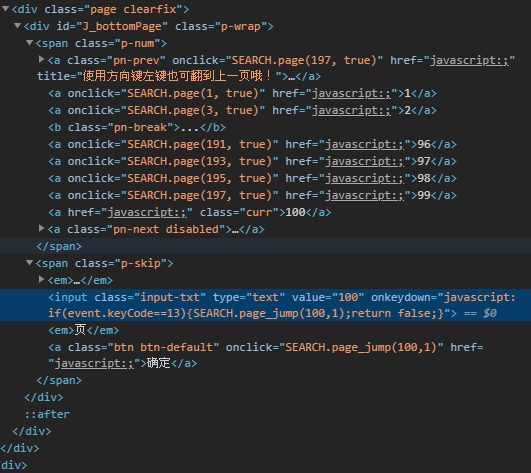

當打開第二頁的時候，在URL中顯示page=3，當翻到第三頁的時候就是page=5，以此類推-1-3-5-7-9。

推估公式: 
> 2n-1, n is current page#

EX. page n: SEARCH.page(2n-1, true)
- page 1: SEARCH.page(1, true)
- page 2: SEARCH.page(3, true)
- page 4: SEARCH.page(7, true)
- page 99: SEARCH.page(197, true)
- page 100: SEARCH.page(199, true)

In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
import re, requests, csv, codecs
from requests.exceptions import RequestException
from bs4 import BeautifulSoup

In [2]:
# 1、要取所有的电脑数据，首先得获得所有电脑的网页源码，以及url地址如下：
def download(url, headers, num_retries=3):
    print("download", url)
    try:
        response = requests.get(url, headers=headers)
        print(response.status_code)
        # 如果相应的状态码为：200 那么return 返回网站源码，如果访问非200则调用重试
        if response.status_code == 200:
            return response.content
        return None
    except RequestException as e:
        print(e.response)
        html = ""
        if hasattr(e.response, 'status_code'):
            code = e.response.status_code
            print('error code', code)
            if num_retries > 0 and 500 <= code < 600:
                html = download(url, headers, num_retries - 1)
        else:
            code = None
    return html

In [3]:
def get_json(url):
    data = requests.get(url).json()
    #print(data)
    result = data['CommentsCount']
    for i in result:
        return i["CommentCountStr"], i["GoodRateShow"]

In [4]:
def write_csv(csv_name, data_list):
    with open(csv_name, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        fields = ('ID', 'NAME', 'PRICE(元)', 'Comment#', 'Good Ratio')
        writer.writerow(fields)
        for data in data_list:
            writer.writerow(data)

In [5]:
def find_Computer(url, headers):
    r = download(url, headers=headers)
    #print(r)
    page = BeautifulSoup(r, "lxml")
    #print(page.prettify())
   
    all_items = page.find_all('li', attrs={'class':'gl-item'})
    data_list = []
    
    for all in all_items:
        Computer_id = all["data-sku"]
        Computer_name = all.find('div', attrs={'class': 'p-name p-name-type-2'}).find('em').text
        _price = all.find('div', attrs={'class': 'p-price'}).find('strong')
        Computer_price = _price.get('data-price', _price.find('i').text)

        # 取每台電腦的Json數據(包含 評價等等信息)
        Comment = f"https://club.jd.com/comment/productCommentSummaries.action?referenceIds={Computer_id}"
        comment_count, good_rate = get_json(Comment)

        #print(f"ID：{Computer_id}")
        #print(f"Name：{Computer_name}")
        #print(f"Price：{Computer_price}元")
        #print(f"Comment#：", comment_count)
        #print(f"Good Ratio：{good_rate}\n")
        row = []
        row.append(Computer_id)
        row.append(Computer_name)
        row.append(str(Computer_price))
        row.append(comment_count)
        row.append(good_rate)
        data_list.append(row)
    return data_list

In [6]:
def main(page_end):
    headers = {
    'User-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36",
    "referer": "https://search.jd.com"
    }
    all_list = []
    
    for page in range(1,page_end*2+1,2):
        URL = f"https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page={page}&s=1&click=0"
        data_list = find_Computer(URL, headers=headers)
        all_list += data_list
        write_csv("leovo.csv", all_list)

In [7]:
if __name__ == '__main__':
    main(10)
    print("\nDONE\n")

download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=1&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=3&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=5&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=7&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=1&wq=lenovo&ev=exbrand_%E8%81%94%E6%83%B3%EF%BC%88Lenovo%EF%BC%89%5E&page=9&s=1&click=0
200
download https://search.jd.com/Search?keyword=lenovo&enc=utf-8&qrst=1&rt=1&stop=1&vt=2&bs=